# Universidad Nacional de Colombia sede Medellín
# Optimización heurística
### Davinson Montoya Ramirez 71277483
### Jessica María Rivera Jiménez 1017205993
### Luis Felipe Arévalo Cortés 1018469500



# 1. Optimización de funciones de prueba

**Importación de Librerías**

In [ ]:
%matplotlib notebook
import plotly.express as px
import plotly.io as pio
import matplotlib.animation as animation
from sympy import *
import numpy as np
import math
from pylab import *
import itertools
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Math
from matplotlib import ticker
from numpy import random
from mpl_toolkits.mplot3d import Axes3D 
import warnings
import copy
import pandas as pd
import time
from datetime import datetime
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmin
from numpy import min
from numpy import around
from matplotlib.colors import BoundaryNorm
from scipy.optimize import differential_evolution
from IPython.display import HTML
warnings.filterwarnings('ignore')

## **Función de Rosenbrock**

In [ ]:
Math(rf'f(x1,x2)=100(x2−x1^2)^2+(1−x1)^2 , xi∈[−2.048,2.048], i=1,2')

<IPython.core.display.Math object>

**Representación grafica función de Rosenbrock**

Se define la función, sabiendo que alcanza su valor mínimo z= 0, cuando x1 = 1 y x2 = 1 

In [ ]:
b = 100;
r = lambda x,y: (x-1)**2 + b*(y-x**2)**2;

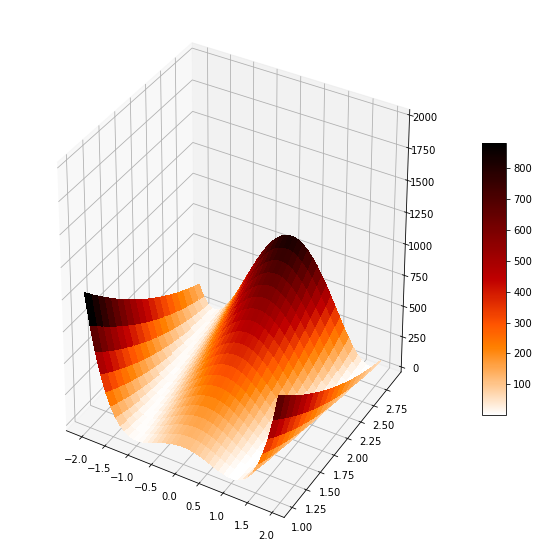

In [ ]:
# Definir figura
figRos = plt.figure(figsize=(10, 10))
axRos = figRos.gca(projection='3d')

# Se evalúa la función
X = np.arange(-2.048, 2.048, 0.1)
Y = np.arange(1, 3, 0.1)
X, Y = np.meshgrid(X, Y)
Z = r(X,Y)

# Gráfica del entorno
surf = axRos.plot_surface(X, Y, Z, cmap=cm.gist_heat_r,
                       linewidth=0, antialiased=False)
axRos.set_zlim(0, 2000)
figRos.colorbar(surf, shrink=0.5, aspect=11)
plt.show()

**Optimización por Método de Descenso de Gradiente para Rosenbrock**


---





En esta sección se define la función, su gradiente y su delta, que será necesarios para calcular la optimización más adelante

In [ ]:
def ros(x, y):
    return (1 - x) ** 2 + 100 * (y - x * x) ** 2

In [ ]:
def rosgrad(x, y):
    return np.matrix([[2 * x - 2 + 400 * x * (x * x - y)],
                      [200 * (y - x * x)]])

In [ ]:
def delta_grad(x, y):
    g = rosgrad(x, y)
    #eta
    alpha = 0.002
    delta = alpha * g
    return delta

A continuación se grafica la función, sus líneas de contorno.  Se define la condición inicial aleatoria del meodelo por descenso de gradiente, y se empiezan a iterar las evaluaciones restando el valor inicial por el delta previemnte definido. Cuando el valor de delta es menor a 0.00001 se termina la iteración, y se grafican los resultados del modelo dentro de la gráfica

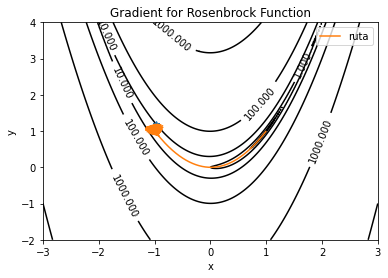

In [ ]:
# ----- Drawing contour lines -----
# Number of data
n = 256
# Define x, y
x = np.linspace(-3, 3, n)
y = np.linspace(-2, 4, n)
# Generate grid data
X, Y = np.meshgrid(x, y)

plt.figure()
# Fill the color of the contour line, 8 is the contour line divided into several parts
plt.contourf(X, Y, ros(X, Y), 5, alpha=0, cmap=plt.cm.hot)
# Draw contour lines
C = plt.contour(X, Y, ros(X, Y), 10, locator=ticker.LogLocator(), colors='black', linewidth=0.01)
# Draw contour data
plt.clabel(C, inline=True, fontsize=10)
#x = np.matrix([[-0.2],[0.4]])
#Condición inicial aleatoria
x = np.random.rand(2,2)* (2.048+2.048) - 2.048
tol = 0.00001
xv = [x[0, 0]]
yv = [x[1, 0]]

plt.plot(x[0, 0], x[1, 0], marker='*')
#Evaluaciones máximas 6000
for t in range(6000):
    delta = delta_grad(x[0, 0], x[1, 0])
    if abs(delta[0, 0]) < tol and abs(delta[1, 0]) < tol:
        break
    x = x - delta
    xv.append(x[0, 0])
    yv.append(x[1, 0])

plt.plot(xv, yv, label='ruta')
#plt.plot(xv, yv, label='track', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient for Rosenbrock Function')
plt.legend()
plt.show()

**Definición de funciones para implementación de Algoritmos evolutivos**

Clase individuo. Se define la clase que conforma al individuo, que pertenecen a los métodos meta heurísticos para buscar soluciones en forma descentralizada

In [ ]:
class Individuo:
    
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):

        # Número de variables del individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Valor de las variables del individuo
        self.valor_variables = np.repeat(None, n_variables)
        # Fitness del individuo
        self.fitness = None
        # Valor de la función objetivo
        self.valor_funcion = None
        
        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf, np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------

        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las 
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las 
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        # BUCLE PARA ASIGNAR UN VALOR A CADA UNA DE LAS VARIABLES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_variables):
        # Para cada variable, se genera un valor aleatorio dentro del rango
        # permitido para esa variable.
            self.valor_variables[i] = random.uniform(
                                        self.limites_inf[i],
                                        self.limites_sup[i]
                                      )

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("Nuevo individuo creado")
            print("----------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("")

    def __repr__(self):

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Valor variables: " + str(self.valor_variables) \
                + "\n" \
                + "Valor función objetivo: " + str(self.valor_funcion) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)

    def calcular_fitness(self, funcion_objetivo, optimizacion, verbose = False):
       
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: 'maximizar' o 'minimizar'"
                )

        # EVALUACIÓN DE LA FUNCIÓN OBJETIVO CON LAS VARIABLES DEL INDIVIDUO Y
        # CÁLCULO DEL FITNESS
        # ----------------------------------------------------------------------
        self.valor_funcion = funcion_objetivo(*self.valor_variables)
        if optimizacion == "maximizar":
            self.fitness = self.valor_funcion
        elif optimizacion == "minimizar":
            self.fitness = -self.valor_funcion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")

    def mutar(self, prob_mut=0.01, distribucion="uniforme", media_distribucion=1,
              sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
              verbose=False):
     

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not distribucion in ["normal", "uniforme", "aleatoria"]:
            raise Exception(
                "El argumento distribucion debe ser: 'normal', 'uniforme' o " \
                + "'aleatoria'"
                )

        # SELECCIÓN PROBABILISTA DE POSICIONES (VARIABLES) QUE MUTAN
        #-----------------------------------------------------------------------
        posiciones_mutadas = np.random.uniform(
                                low=0,
                                high=1,
                                size=self.n_variables
                             )
        posiciones_mutadas = posiciones_mutadas > prob_mut

        # MODIFICACIÓN DE LOS VALORES DE LAS VARIABLES SELECCIONADAS
        #-----------------------------------------------------------------------
        # Si la distribución seleccionada es "uniforme" o "normal", se extrae un
        # valor aleatorio de la distribución elegida que se suma para modificar
        # la/las posiciones mutadas.

        if distribucion in ["normal", "uniforme"]:
            if distribucion == "normal":
                factor_mut = np.random.normal(
                                loc   = media_distribucion,
                                scale = sd_distribucion,
                                size  = np.sum(posiciones_mutadas)
                             )
            if distribucion == "uniforme":
                factor_mut = np.random.uniform(
                                low  = min_distribucion,
                                high = max_distribucion,
                                size = np.sum(posiciones_mutadas)
                             )
            self.valor_variables[posiciones_mutadas] = \
                self.valor_variables[posiciones_mutadas] + factor_mut

            # Se comprueba si algún valor mutado supera los límites impuestos.
            # En tal caso se sobrescribe con el valor del límite correspondiente.
            for i in np.flatnonzero(posiciones_mutadas):
                if self.valor_variables[i] < self.limites_inf[i]:
                    self.valor_variables[i] = self.limites_inf[i]
                if self.valor_variables[i] > self.limites_sup[i]:
                    self.valor_variables[i] = self.limites_sup[i]

        # Si la distribución seleccionada es "aleatoria", se sobreescribe el
        # valor de la variable con un nuevo valor aleatorio dentro de los 
        # límites establecidos.
        if distribucion == "aleatoria":
            for i in np.flatnonzero(posiciones_mutadas):
                self.valor_variables[i] = random.uniform(
                                            self.limites_inf[i],
                                            self.limites_sup[i]
                                          )
        # REINICIO DEL VALOR Y DEL FITNESS
        #-----------------------------------------------------------------------
        # Dado que el individuo ha mutado, el valor de su fitness y de la
        # función objetivo ya no son validos.
        self.fitness = None
        self.valor_funcion = None

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Total mutaciones: " + str(np.sum(posiciones_mutadas)))
            print("Valor variables: " + str(self.valor_variables))
            print("")

Clase Población:

In [ ]:
class Poblacion:

    def __init__(self, n_individuos, n_variables, limites_inf=None,
                 limites_sup=None, verbose=False):

        # Número de individuos de la población
        self.n_individuos = n_individuos
        # Número de variables de cada individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Lista de los individuos de la población
        self.individuos = []
        # Etiqueta para saber si la población ha sido optimizada
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor individuo de la población
        self.mejor_individuo = None
        # Fitness del mejor individuo de la población (el de mayor fitness)
        self.mejor_fitness = None
        # Valor de la función objetivo del mejor individuo de la población
        self.mejor_valor_funcion = None
        # Valor de las variables del mejor individuo de la población
        self.mejor_valor_variables = None
        # Información de todas los individuos de la población en cada generación
        self.historico_individuos = []
        # Valor de las variables del mejor individuo en cada generación
        self.historico_mejor_valor_variables = []
        # Fitness del mejor individuo en cada generación
        self.historico_mejor_fitness = []
        # Valor de la función objetivo del mejor individuo en cada generación
        self.historico_mejor_valor_funcion = []
        # Diferencia absoluta entre el mejor fitness de generaciones consecutivas
        self.diferencia_abs = []
        # data.frame con la información del mejor fitness y valor de variables
        # encontrado en cada generación, así como la diferencia respecto a la 
        # generación anterior.
        self.resultados_df = None
        # Fitness del mejor individuo de todas las generaciones
        self.fitness_optimo = None
        # Valor de las variables del mejor individuo de todas las generaciones
        self.valor_variables_optimo = None
        # Valor de función objetivo del mejor individuo de todas las generaciones
        self.valor_funcion_optimo = None

        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # SE CREAN LOS INDIVIDUOS DE LA POBLACIÓN Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_individuos):
            individuo_i = Individuo(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = verbose
                          )
            self.individuos.append(individuo_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto población.

        """

        texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                     + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Valor variables: " + str(self.mejor_valor_variables) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Valor óptimo de variables: " + str(self.valor_variables_optimo) \
                + "\n" \
                + "Valor óptimo función objetivo: " + str(self.valor_funcion_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)
                
                
        return(texto)

    def mostrar_individuos(self, n=None):
       
        if n is None:
            n = self.n_individuos
        elif n > self.n_individuos:
            n = self.n_individuos

        for i in np.arange(n):
            print(self.individuos[i])
        return(None)

    def evaluar_poblacion(self, funcion_objetivo, optimizacion, verbose=False):
      
        # SE EVALÚA CADA INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos):
            self.individuos[i].calcular_fitness(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
            )

        # MEJOR INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        # Se identifica el mejor individuo de toda el población, el de mayor
        # fitness.

        # Se selecciona inicialmente como mejor individuo el primero.
        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        # Se comparan todas los individuos de la población.
        for i in np.arange(self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        # Se extrae la información del mejor individuo de la población.
        self.mejor_fitness = self.mejor_individuo.fitness
        self.mejor_valor_variables = self.mejor_individuo.valor_variables
        self.mejor_valor_funcion = self.mejor_individuo.valor_funcion
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Valor de la función objetivo: " \
                + str(self.mejor_valor_funcion))
            print("Mejor valor de variables encontrado : "
                + str(self.mejor_valor_variables))
            print("")

    def cruzar_individuos(self, parental_1, parental_2, verbose=False):
      
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if parental_1 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_1 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        if parental_2 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_2 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )

        # CREACIÓN DE LA DESCENDENCIA
        # ----------------------------------------------------------------------
        # Se extraen los parentales acorde a los índices indicados.
        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]
        
        # Se clona uno de los parentales para utilizarlo como plantilla del nuevo
        # individuo.
        descendencia = copy.deepcopy(parental_1)
        descendencia.valor_variables = np.repeat(None, descendencia.n_variables)
        descendencia.fitness = None

        # Se seleccionan aleatoriamente las posiciones que se heredan del
        # parental_1 y del parental 2.
        herencia_parent_1 = np.random.choice(
                                a       = [True, False],
                                size    = descendencia.n_variables,
                                p       = [0.5, 0.5],
                                replace = True
                            )
        herencia_parent_2 = np.logical_not(herencia_parent_1)

        # Se transfieren los valores al nuevo individuo.
        descendencia.valor_variables[herencia_parent_1] \
            = parental_1.valor_variables[herencia_parent_1]

        descendencia.valor_variables[herencia_parent_2] \
            = parental_2.valor_variables[herencia_parent_2]
        
        # Se crea un deepcopy para que el nuevo individuo sea independiente de 
        # los parentales. Esto evita problemas si posteriormente se muta.
        descendencia = copy.deepcopy(descendencia)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------------------------")
            print("Cruce realizado: descendencia creada")
            print("------------------------------------")
            print("Valor variables: " + str(descendencia.valor_variables))
            print("")
        return(descendencia)
    
    def seleccionar_individuo(self, n, return_indices=True,
                              metodo_seleccion="tournament", verbose=False):
        

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metodo_seleccion not in ["ruleta", "rank", "tournament"]:
            raise Exception(
                "El método de selección debe de ser ruleta, rank o tournament"
                )

        # SELECCIÓN DE INDIVIDUOS
        # ----------------------------------------------------------------------
        # Se crea un array con el fitness de cada individuo de la población.
        array_fitness = np.repeat(None, self.n_individuos)
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)
        
        # Se calcula la probabilidad de selección de cada individuo en función
        # de su fitness.
        if metodo_seleccion == "ruleta":
            probabilidad_seleccion = array_fitness / np.sum(array_fitness)
            ind_seleccionado = np.random.choice(
                                    a       = np.arange(self.n_individuos),
                                    size    = n,
                                    p       = list(probabilidad_seleccion),
                                    replace = True
                               )
        elif metodo_seleccion == "rank":
            # La probabilidad con este método es inversamente proporcional a la
            # posición en la que quedan ordenados los individuos de menor a mayor
            # fitness.
            order = np.flip(np.argsort(a=array_fitness) + 1)
            ranks = np.argsort(order) + 1
            probabilidad_seleccion = 1 / ranks
            probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
            ind_seleccionado = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = n,
                                p       = list(probabilidad_seleccion),
                                replace = True
                            )
        elif metodo_seleccion == "tournament":
            ind_seleccionado = np.repeat(None,n)
            for i in np.arange(n):
                # Se seleccionan aleatoriamente dos parejas de individuos.
                candidatos_a = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                candidatos_b = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                # De cada pareja se selecciona el de mayor fitness.
                if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                    ganador_a = candidatos_a[0]
                else:
                    ganador_a = candidatos_a[1]

                if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                    ganador_b = candidatos_b[0]
                else:
                    ganador_b = candidatos_b[1]

                # Se comparan los dos ganadores de cada pareja.
                if array_fitness[ganador_a] > array_fitness[ganador_b]:
                    ind_final = ganador_a
                else:
                    ind_final = ganador_b
                
                ind_seleccionado[i] = ind_final

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Individuo seleccionado")
            print("----------------------")
            print("Método selección: " + metodo_seleccion)
            print("")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )
            
    def crear_nueva_generecion(self, metodo_seleccion="tournament",
                               elitismo=0.1, prob_mut=0.01,
                               distribucion="uniforme",
                               media_distribucion=1, sd_distribucion=1,
                               min_distribucion=-1, max_distribucion=1,
                               verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):
      

        # Lista donde almacenar los individuos de la nueva generación.
        nuevos_individuos = []

        # ELITISMO
        # ----------------------------------------------------------------------
        if elitismo > 0:
            # Número de individuos que pasan directamente a la siguiente
            # generación.
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))

            # Se identifican los n_elitismo individuos con mayor fitness (élite).
            array_fitness = np.repeat(None, self.n_individuos)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness))
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            # Se añaden los individuos élite a la lista de nuevos individuos.
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0
            
        # CREACIÓN DE NUEVOS INDIVIDUOS POR CRUCES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    metodo_seleccion = metodo_seleccion,
                                    verbose          = verbose_seleccion
                                 )
            # Cruzar parentales para obtener la descendencia
            descendencia = self.cruzar_individuos(
                            parental_1 = indice_parentales[0],
                            parental_2 = indice_parentales[1],
                            verbose    = verbose_cruce
                           )
            # Mutar la descendencia
            descendencia.mutar(
                prob_mut         = prob_mut,
                distribucion     = distribucion,
                min_distribucion = min_distribucion,
                max_distribucion = max_distribucion,
                verbose          = verbose_mutacion
            )
            # Se añade la descendencia a la lista de nuevos individuos. Para
            # que no de error la unión, se introduce el individuo descendencia
            # dentro de una lista.
            nuevos_individuos = nuevos_individuos + [descendencia]

        # ACTUALIZACIÓN INFORMACIÓN DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_variables = None
        self.mejor_valor_funcion = None
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------------")
            print("Nueva generación creada")
            print("-----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")

    def optimizar(self, funcion_objetivo, optimizacion, n_generaciones = 50,
                  metodo_seleccion="tournament", elitismo=0.1, prob_mut=0.01,
                  distribucion="uniforme", media_distribucion=1,
                  sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None,verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):
       

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # ITERACIONES (GENERACIONES)
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")
            
            # EVALUAR INDIVIDUOS DE LA POBLACIÓN
            # ------------------------------------------------------------------
            self.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose_evaluacion
                )

            # SE ALMACENA LA INFORMACIÓN DE LA GENERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_valor_variables.append(
                                    copy.deepcopy(self.mejor_valor_variables)
                                )
            self.historico_mejor_valor_funcion.append(
                                    copy.deepcopy(self.mejor_valor_funcion)
                                )

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA GENERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # generación.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores individuos no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break
            
            # CREAR UNA NUEVA GENERACIÓN
            # ------------------------------------------------------------------         
            self.crear_nueva_generecion(
                metodo_seleccion   = metodo_seleccion,
                elitismo           = elitismo,
                prob_mut           = prob_mut,
                distribucion       = distribucion,
                verbose            = verbose_nueva_generacion,
                verbose_seleccion  = verbose_seleccion,
                verbose_cruce      = verbose_cruce,
                verbose_mutacion   = verbose_mutacion
                )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_funcion_optimo = self\
                                    .historico_mejor_valor_funcion[indice_valor_optimo]
        self.valor_variables_optimo = self\
                                      .historico_mejor_valor_variables[indice_valor_optimo]
        
        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_funcion"  : self.historico_mejor_fitness,
            "mejor_valor_variables": self.historico_mejor_valor_variables,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Valor óptimo de las variables: " + str(self.valor_variables_optimo))
        print("Valor función objetivo: " + str(self.valor_funcion_optimo))
        print("")

**Optimización de la función Rosenbrok por algoritmos genéticos**

Con la clase individuo y población previamente definida, se modifican los parámetro de la población y la función optimizar del modelo, incluyendo nuestra función matemática y seleccionando el método de búsqueda tournament.

In [ ]:
poblacion = Poblacion(
                n_individuos = 40,
                n_variables  = 2,
                limites_inf  = [-2, -2],
                limites_sup  = [3, 3],
                verbose      = False
            )

poblacion.optimizar(
    funcion_objetivo   = ros,
    optimizacion       = "minimizar",
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 16 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2021-07-28 00:32:17
-------------------------------------------
Duración optimización: 0.27008986473083496
Número de generaciones: 16
Valor óptimo de las variables: [0.6973977011822736 0.5262926513043582]
Valor función objetivo: 0.2510014354838354



Información detallada de la población luego de la optimización en la función rosenbrock

In [ ]:
poblacion

         Población
Número de individuos: 40
Límites inferiores de cada variable: [-2 -2]
Límites superiores de cada variable: [3 3]
Optimizado: True
Iteraciones optimización (generaciones): 16

Información del mejor individuo:
----------------------------
Valor variables: [0.6973977011822736 0.5262926513043582]
Fitness: -0.2510014354838354

Resultados tras optimizar:
--------------------------
Valor óptimo de variables: [0.6973977011822736 0.5262926513043582]
Valor óptimo función objetivo: 0.2510014354838354
Fitness óptimo: -0.2510014354838354

Se observa que se crean 17 generaciones de individuos para llegar al óptimo más cercano del valor que esperábamos.

Evolución del mejor individuo

En la siguiente gráfica se muestra cómo evoluciona la solución a medida que pasan las generaciones

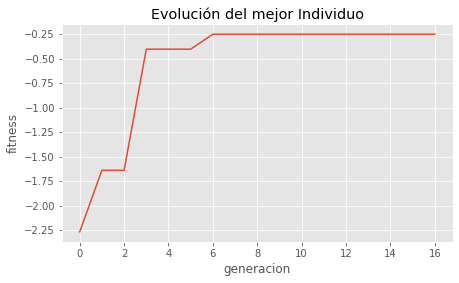

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7, 4))
poblacion.resultados_df.plot(x = "generacion",
                             y = "mejor_fitness",
                             ax= ax)
ax.set(title='Evolución del mejor Individuo', xlabel='generacion', ylabel='fitness')
ax.legend().set_visible(False)

Se observa que de la gráfica, desde la generación 6 empieza a tener un comportamiento constante de aquí en adelante

**Gif animado mejor individuo Rosenbrock**

La información de la población es almacenada en un dataframe que contiene la generación donde se encuentra, su posición en x y en y

In [ ]:
def extraer_posicion(individuo):
    posicion = individuo.valor_variables
    return(posicion)

lista_df_temp = []

for i in np.arange(len(poblacion.historico_individuos)):
    posiciones = list(map(extraer_posicion, poblacion.historico_individuos[i]))
    df_temp = pd.DataFrame({"generacion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,generacion,posicion,x_0,x_1
0,0,"[0.8897914206251825, -0.1610346658079842]",0.889791,-0.161035
1,0,"[2.348440524816673, 1.1875621525615419]",2.348441,1.187562
2,0,"[2.3964370446024263, 2.293678098913402]",2.396437,2.293678
3,0,"[0.6306965747813837, 0.5778783364822551]",0.630697,0.577878
4,0,"[-0.5789175947910301, 1.973809533889177]",-0.578918,1.973810


In [ ]:
!pip install -q plotly==4.2.1

En este paso se define la animación en el movimiento de los individuos en cada generación

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8,5))
plt.xlim(-2,2)
plt.ylim(-1,3)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-2,2)
    plt.ylim(-1,3)
    df_posiciones_i = df_posiciones[df_posiciones["generacion"] == i][["x_0", "x_1"]]
    p1 = plt.contour(X, Y, ros(X, Y), 35, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_0"], df_posiciones_i["x_1"])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=25, blit = True)

<IPython.core.display.Javascript object>

Se muestra de forma animada cómo se mueven los individuos, y convergen a la solución espérada

In [ ]:
px.scatter(
    df_posiciones,
    x       = "x_0",
    y       = "x_1",
    range_x = [-4, 4],
    range_y = [-4, 4],
    animation_frame = "generacion"
)

In [ ]:
# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=1800)
ani.save("/content/animacion_ga_ros.mp4", writer=writer)

En esta parte se muestran el movimiento de la población en la función objetivo

In [ ]:
HTML(ani.to_html5_video())
#%%HTML
#<div align="middle">
#<video width="60%" controls>
#     <source src="/content/animacion_ga_ros.mp4", type="video/mp4">
#</video></div>

**Definición funciones para implementación de Enjambre de Partículas**

PSO hace referencia a un algoritmo metaheurístico que simula el comportamiento de las partículas en la naturaleza. Esto permite optimizar un problema a partir de una población de soluciones candidatas llamas "Partículas", donde estas se mueven por todo el espacio de búsqueda, donde se tienen en cuenta la posición y la velocidad de cada partícula. Este movimiento es infludio por su mejor posición local encontrada hasta el momento, así como las mejores posiciones en forma global, encontradas por otras partículas. La idea es que el conjunto de partículas converga rápidamente a las mejores soluciones.

**Clase Partícula**

Se defnie la clase partícula para el ejecicio propuesto.

In [ ]:
class Particula:
    
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):

        # Número de variables de la partícula
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Posición de la partícula
        self.posicion = np.repeat(None, n_variables)
        # Velocidad de la parícula
        self.velocidad = np.repeat(None, n_variables)
        # Valor de la partícula
        self.valor = np.repeat(None, 1)
        # Mejor valor que ha tenido la partícula hasta el momento
        self.mejor_valor = None
        # Mejor posición en la que ha estado la partícula hasta el momento
        self.mejor_posicion = None
        
        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------

        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las 
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las 
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        # BUCLE PARA ASIGNAR UN VALOR A CADA UNA DE LAS VARIABLES QUE DEFINEN LA
        # POSICIÓN
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_variables):
        # Para cada posición, se genera un valor aleatorio dentro del rango
        # permitido para esa variable.
            self.posicion[i] = random.uniform(
                                    self.limites_inf[i],
                                    self.limites_sup[i]
                                )

        # LA VELOCIDAD INICIAL DE LA PARTÍCULA ES 0
        # ----------------------------------------------------------------------
        self.velocidad = np.repeat(0, self.n_variables)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("Nueva partícula creada")
            print("----------------------")
            print("Posición: " + str(self.posicion))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("Velocidad: " + str(self.velocidad))
            print("")

    def __repr__(self):


        texto = "Partícula" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Posición: " + str(self.posicion) \
                + "\n" \
                + "Velocidad: " + str(self.velocidad) \
                + "\n" \
                + "Mejor posicion: " + str(self.mejor_posicion) \
                + "\n" \
                + "Mejor valor: " + str(self.mejor_valor) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)

    def evaluar_particula(self, funcion_objetivo, optimizacion, verbose = False):
       

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: maximizar o minimizar"
                )

        # EVALUACIÓN DE LA FUNCIÓN OBJETIVO EN LA POSICIÓN ACTUAL
        # ----------------------------------------------------------------------
        self.valor = funcion_objetivo(*self.posicion)

        # MEJOR VALOR Y POSICIÓN
        # ----------------------------------------------------------------------
        # Se compara el valor actual con el mejor valor histórico. La comparación
        # es distinta dependiendo de si se desea maximizar o minimizar.
        # Si no existe ningún valor histórico, se almacena el actual. Si ya existe
        # algún valor histórico se compara con el actual y, de ser mejor este
        # último, se sobrescribe.
        
        if self.mejor_valor is None:
            self.mejor_valor    = np.copy(self.valor)
            self.mejor_posicion = np.copy(self.posicion)
        else:
            if optimizacion == "minimizar":
                if self.valor < self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)
            else:
                if self.valor > self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("La partícula ha sido evaluada")
            print("-----------------------------")
            print("Valor actual: " + str(self.valor))
            print("")

    def mover_particula(self, mejor_p_enjambre, inercia=0.8, peso_cognitivo=2,
                        peso_social=2, verbose=False):


        # ACTUALIZACIÓN DE LA VELOCIDAD
        # ----------------------------------------------------------------------
        componente_velocidad = inercia * self.velocidad
        r1 = np.random.uniform(low=0.0, high=1.0, size = len(self.velocidad))
        r2 = np.random.uniform(low=0.0, high=1.0, size = len(self.velocidad))
        componente_cognitivo = peso_cognitivo * r1 * (self.mejor_posicion \
                                                      - self.posicion)
        componente_social = peso_social * r2 * (mejor_p_enjambre \
                                                - self.posicion)
        nueva_velocidad = componente_velocidad + componente_cognitivo \
                          + componente_social
        self.velocidad = np.copy(nueva_velocidad)
        
        # ACTUALIZACIÓN DE LA POSICIÓN
        # ----------------------------------------------------------------------
        self.posicion = self.posicion + self.velocidad

        # COMPROBAR LÍMITES
        # ----------------------------------------------------------------------
        # Se comprueba si algún valor de la nueva posición supera los límites
        # impuestos. En tal caso, se sobrescribe con el valor del límite
        # correspondiente y se reinicia a 0 la velocidad de la partícula en esa
        # componente.
        for i in np.arange(len(self.posicion)):
            if self.posicion[i] < self.limites_inf[i]:
                self.posicion[i] = self.limites_inf[i]
                self.velocidad[i] = 0

            if self.posicion[i] > self.limites_sup[i]:
                self.posicion[i] = self.limites_sup[i]
                self.velocidad[i] = 0
                
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("La partícula se ha desplazado")
            print("-----------------------------")
            print("Nueva posición: " + str(self.posicion))
            print("")

**Clase Enjambre**

Se define la clase enjambre para contener a toda la población de partículas

In [ ]:
class Enjambre:

    def __init__(self, n_particulas, n_variables, limites_inf = None,
                 limites_sup = None, verbose = False):

        # Número de partículas del enjambre
        self.n_particulas = n_particulas
        # Número de variables de cada partícula
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Verbose
        self.verbose = verbose
        # Lista de las partículas del enjambre
        self.particulas = []
        # Etiqueta para saber si el enjambre ha sido optimizado
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor partícula del enjambre
        self.mejor_particula = None
        # Mejor valor del enjambre
        self.mejor_valor = None
        # Posición del mejor valor del enjambre.
        self.mejor_posicion = None
        # Estado de todas las partículas del enjambre en cada iteración.
        self.historico_particulas = []
        # Mejor posición en cada iteración.
        self.historico_mejor_posicion = []
        # Mejor valor en cada iteración.
        self.historico_mejor_valor = []
        # Diferencia absoluta entre el mejor valor de iteraciones consecutivas.
        self.diferencia_abs = []
        # data.frame con la información del mejor valor y posición encontrado en
        # cada iteración, así como la mejora respecto a la iteración anterior.
        self.resultados_df = None
        # Mejor valor de todas las iteraciones
        self.valor_optimo = None
        # Mejor posición de todas las iteraciones
        self.posicion_optima = None

        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # SE CREAN LAS PARTÍCULAS DEL ENJAMBRE Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_particulas):
            particula_i = Particula(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = self.verbose
                          )
            self.particulas.append(particula_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------")
            print("Enjambre creado")
            print("---------------")
            print("Número de partículas: " + str(self.n_particulas))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

    def __repr__(self):
        
        texto = "============================" \
                + "\n" \
                + "         Enjambre" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de partículas: " + str(self.n_particulas) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización: " + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información mejor partícula:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Mejor posición actual: " + str(self.mejor_posicion) \
                + "\n" \
                + "Mejor valor actual: " + str(self.mejor_valor) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Posición óptima: " + str(self.posicion_optima) \
                + "\n" \
                + "Valor óptimo: " + str(self.valor_optimo)
                
        return(texto)

    def mostrar_particulas(self, n=None):
       
        if n is None:
            n = self.n_particulas
        elif n > self.n_particulas:
            n = self.n_particulas

        for i in np.arange(n):
            print(self.particulas[i])
        return(None)

    def evaluar_enjambre(self, funcion_objetivo, optimizacion, verbose = False):

        # SE EVALÚA CADA PARTÍCULA DEL ENJAMBRE
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_particulas):
            self.particulas[i].evaluar_particula(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
                )

        # MEJOR PARTÍCULA DEL ENJAMBRE
        # ----------------------------------------------------------------------
        # Se identifica la mejor partícula de todo el enjambre. Si se está
        # maximizando, la mejor partícula es aquella con mayor valor.
        # Lo contrario si se está minimizando.

        # Se selecciona inicialmente como mejor partícula la primera.
        self.mejor_particula =  copy.deepcopy(self.particulas[0])
        # Se comparan todas las partículas del enjambre.
        for i in np.arange(self.n_particulas):
            if optimizacion == "minimizar":
                if self.particulas[i].valor < self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])
            else:
                if self.particulas[i].valor > self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])

        # Se extrae la posición y valor de la mejor partícula y se almacenan
        # como mejor valor y posición del enjambre.
        self.mejor_valor    = self.mejor_particula.valor
        self.mejor_posicion = self.mejor_particula.posicion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------")
            print("Enjambre evaluado")
            print("-----------------")
            print("Mejor posición encontrada : "
                  + np.array2string(self.mejor_posicion))
            print("Mejor valor encontrado : " + str(self.mejor_valor))
            print("")

    def mover_enjambre(self, inercia, peso_cognitivo, peso_social,
                       verbose = False):
 
        # Se actualiza la posición de cada una de las partículas que forman el
        # enjambre.
        for i in np.arange(self.n_particulas):
            self.particulas[i].mover_particula(
                mejor_p_enjambre = self.mejor_posicion,
                inercia          = inercia,
                peso_cognitivo   = peso_cognitivo,
                peso_social      = peso_social,
                verbose          = verbose
            )

        # Información del proceso (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------------------------------------------------" \
                  "------------")
            print("La posición de todas las partículas del enjambre ha sido " \
                  "actualizada.")
            print("---------------------------------------------------------" \
            "------------")
            print("")


    def optimizar(self, funcion_objetivo, optimizacion, n_iteraciones = 50,
                  inercia = 0.8, reduc_inercia = True, inercia_max = 0.9,
                  inercia_min = 0.4, peso_cognitivo = 2, peso_social = 2,
                  parada_temprana = False, rondas_parada = None,
                  tolerancia_parada  = None, verbose = False):
      

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )
        
        # Si se activa la reducción de inercia, hay que especificar los argumentos
        # inercia_max y inercia_min.
        if reduc_inercia \
        and (inercia_max is None or inercia_min is None):
            raise Exception(
            "Para activar la reducción de inercia es necesario indicar un " \
            + "valor de inercia_max y de inercia_min."
            )

        # ITERACIONES
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_iteraciones):
            if verbose:
                print("-------------")
                print("Iteracion: " + str(i))
                print("-------------")
            
            # EVALUAR PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
            enjambre.evaluar_enjambre(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = verbose
                )

            # SE ALMACENA LA INFORMACIÓN DE LA ITERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_particulas.append(copy.deepcopy(self.particulas))
            self.historico_mejor_posicion.append(copy.deepcopy(self.mejor_posicion))
            self.historico_mejor_valor.append(copy.deepcopy(self.mejor_valor))

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA ITERACION ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # iteración.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_valor[i] \
                                 - self.historico_mejor_valor[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores partículas no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la iteracion " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " iteraciones consecutivas.")
                    break
            
            # MOVER PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
            # Si se ha activado la reducción de inercia, se recalcula su valor 
            # para la iteración actual.
            if reduc_inercia:
                inercia = ((inercia_max - inercia_min) \
                          * (n_iteraciones-i)/n_iteraciones) \
                          + inercia_min
           
            enjambre.mover_enjambre(
               inercia        = inercia,
               peso_cognitivo = peso_cognitivo,
               peso_social    = peso_social,
               verbose        = False
            )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmin(np.array(self.historico_mejor_valor))
        self.valor_optimo    = self.historico_mejor_valor[indice_valor_optimo]
        self.posicion_optima = self.historico_mejor_posicion[indice_valor_optimo]
        
        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_valor_enjambre"   : self.historico_mejor_valor,
            "mejor_posicion_enjambre": self.historico_mejor_posicion,
            "diferencia_abs"         : self.diferencia_abs
            }
        )
        self.resultados_df["iteracion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de iteraciones: " + str(self.iter_optimizacion))

**Optimizando Función Rosenbrock con enjambres**

Se declara el enjambre de 50 partículas, con límites de búsqueda entre -3 y 3 tanto en x como en y. Se relaciona la función objetivo que se viene trabajando, y se define un número máximo de iteraciones de 250.

In [ ]:
enjambre = Enjambre(
               n_particulas = 50,
               n_variables  = 2,
               limites_inf  = [-3, -3],
               limites_sup  = [3, 3],
               verbose      = False
            )

enjambre.optimizar(
    funcion_objetivo = ros,
    optimizacion     = "minimizar",
    n_iteraciones    = 250,
    inercia          = 0.8,
    reduc_inercia    = True,
    inercia_max      = 0.9,
    inercia_min      = 0.4,
    peso_cognitivo   = 1,
    peso_social      = 2,
    parada_temprana  = True,
    rondas_parada    = 5,
    tolerancia_parada = 10**-3,
    verbose          = False
)

Algoritmo detenido en la iteracion 193 por falta cambio absoluto mínimo de 0.001 durante 5 iteraciones consecutivas.
-------------------------------------------
Optimización finalizada 2021-07-28 00:32:34
-------------------------------------------
Duración optimización: 1.097820520401001
Número de iteraciones: 193


Información adicional de la optimización con enjambres

In [ ]:
enjambre

         Enjambre
Número de partículas: 50
Límites inferiores de cada variable: [-3 -3]
Límites superiores de cada variable: [3 3]
Optimizado: True
Iteraciones optimización: 193

Información mejor partícula:
----------------------------
Mejor posición actual: [1.001778285097948 1.004544359679905]
Mejor valor actual: 0.00010011136745416001

Resultados tras optimizar:
----------------------------
Posición óptima: [1.0000396763840425 0.9997663401091985]
Valor óptimo: 9.799365227882484e-06

Evolución de la optimización

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


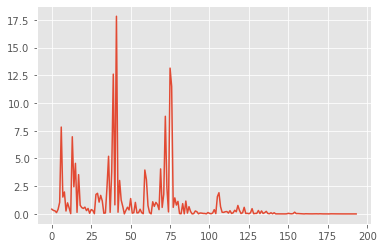

In [ ]:
%matplotlib inline
# Evolución de la optimización
fig = plt.figure(figsize=(6,4))
enjambre.resultados_df['mejor_valor_enjambre'].plot()

De lo anterior se observa que desde la iteración 145 proximadamente hay una convergencia en las soluciones del enjambre.

**Gif animado optimización para la función Rosenbrock con enjambres**

Se crea un dataframe para almacenar las posiciones y número de iteración que contine cada partícula. 

In [ ]:
# Representación Función con enjambres gráfico animado.

# Se extrae la posición de las partículas en cada iteración del enjambre

def extraer_posicion(particula):
    posicion = particula.posicion
    return(posicion)

lista_df_temp = []

for i in np.arange(len(enjambre.historico_particulas)):
    posiciones = list(map(extraer_posicion, enjambre.historico_particulas[i]))
    df_temp = pd.DataFrame({"iteracion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,iteracion,posicion,x_0,x_1
0,0,"[-0.45633891158112316, 2.511985454032793]",-0.456339,2.511985
1,0,"[-2.325220527709086, 0.10472378831421292]",-2.325221,0.104724
2,0,"[2.640365248309287, 1.8320732517449123]",2.640365,1.832073
3,0,"[2.6540575049157287, 0.8873985233198081]",2.654058,0.887399
4,0,"[-1.2718270852290061, -1.616250562226231]",-1.271827,-1.616251


Con la anterior tabla, se representa animadamente el comportamiento del enjambre a medida que aumentan las iteraciones

In [ ]:
px.scatter(
    df_posiciones,
    x       = "x_0",
    y       = "x_1",
    range_x = [-4, 4],
    range_y = [-4, 4],
    animation_frame = "iteracion"
)

Se define la animcaicón de otra manera para que se pueda observar su convergencia con la función objetivo al fondo del espacio de búsqueda.

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8,5))
plt.xlim(-3,3)
plt.ylim(-2,3)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-3,3)
    plt.ylim(-2,3)
    df_posiciones_i = df_posiciones[df_posiciones["iteracion"] == i][["x_0", "x_1"]] #select data range
    p1 = plt.contour(X, Y, ros(X, Y), 35, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_0"], df_posiciones_i["x_1"])

ani2 = matplotlib.animation.FuncAnimation(fig, animate, repeat = True, blit = True)

<IPython.core.display.Javascript object>

In [ ]:
# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, bitrate=1800)
ani2.save('animacion_pso_ros.mp4', writer=writer)

Se muestra el video de las soluciones cómo convergen al punto 1,1

In [ ]:
HTML(ani2.to_html5_video())

**Evolución Diferencial**

La ED contiene una población de soluciones candidatas, donde se recombinan y mutan para producir nuevos individuos que son elegidos de acuerdo a su función de desempeño. Lo que caracteriza a la ED es el uso de vectores de prueba, los cuales compiten con los individuos de la población actual a fin de sobrevivir.

**Optimización de la funcion Rosenbrock por evolución diferencial**

Definición de clases y evaluación

In [ ]:
# objective function
def objros(v):
	x, y = v
	return (x-1)**2 + 100*(y-x**2)**2

#Almacenando la información del progreso
progress = []
progress_val = []

def cb(v, convergence):
    progress.append(v)
    progress_val.append(objros(v))
 
# define range for input
r_min, r_max = -5.0, 5.0
# define the bounds on the search
bounds = [[r_min, r_max], [r_min, r_max]]

# perform the differential evolution search
result = differential_evolution(objros, bounds, disp=False, callback=cb)

progress = np.array(progress)
progress_val = np.array(progress_val)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objros(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 3693
Solution: f([1. 1.]) = 0.00000


Gráfica de la solución

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2,1,2)
ax.plot(progress_val)
ax.set_title('Convergencia de la solución en cada iteración')
plt.show()

<IPython.core.display.Javascript object>

Se observa que la solución converge mucho más rápido en este método que en los algoritmos evolutivos y optimización por enjambres.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(progress[:,0],progress[:,1])
ax.set_title('Valores que toma (x,y)')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Valores que toma (x,y)')

Anteriormente se realizó la optimización básica utilizando una librería conocida. Ahora se define la evolución diferencial para observar el comportamiento de la población en forma animada.

In [ ]:
class DifferentialEvolution:

    def __init__(self, scaling_rate, crossover_rate, population_size):
        self.scaling_rate = scaling_rate
        self.crossover_rate = crossover_rate
        self.population_size = population_size
        self.ranges = []
        
        self.generation_counter = 0
        
        self.all_generations = []
        self.min_std_criterion = 0.001
    
    def set_range(self, paramkey, range):
        self.ranges.append([paramkey, range])
    
    def set_objective(self, objective):
        self.objective = objective
    
    def init_generation(self):
        self.n_params = len(self.ranges)
        self.generation = np.zeros(shape=(self.population_size, self.n_params))
        for p in range(self.n_params):
            low = self.ranges[p][1][0]
            high = self.ranges[p][1][1]
            self.generation[:, p] = np.random.uniform(low, high, size=self.population_size)
    
    def get_trials(self):
        self.trials = np.zeros(shape=(self.population_size, self.n_params))
        for i in range(self.population_size):
            target = self.generation[i, :]
            mutant = self.mutate(i)
            self.trials[i, :] = self.crossover(mutant, target)
    
    def get_candidates(self, i):
        to_select = list(np.arange(self.population_size))
        to_select.remove(i)
        candidates = np.random.choice(to_select, 3, replace=False)
        return candidates
    
    def mutate(self, i):
        candidates = self.get_candidates(i)
        difference_vector = self.generation[candidates[1]] - self.generation[candidates[2]]
        mutant = self.generation[candidates[0]] + self.scaling_rate * difference_vector
        return mutant
    
    def crossover(self, mutant, target):
        crossover_units = np.random.uniform(0, 1, self.n_params)
        trial = np.copy(target)
        random_parameter = np.random.choice(self.n_params)
        for param in range(self.n_params):
            if crossover_units[param] <= self.crossover_rate or param == random_parameter:
                trial[param] = mutant[param]
        return trial
    
    def select(self, generation_costs, trials_costs):
        idx = np.where(trials_costs < generation_costs)[0]
        for i in idx:
            self.generation[i, :] = self.trials[i, :]

    def compute_cost(self):
        generation_costs = self.objective(self.generation)
        trials_cost = self.objective(self.trials)
        return generation_costs, trials_cost
    
    def evolve(self):
        self.init_generation()
        self.all_generations.append(self.generation)
        self.best_solutions = []
        gen_costs = self.objective(self.generation)
        while ((np.std(gen_costs) > self.min_std_criterion) and (self.generation_counter < 200)):
            self.get_trials()
            gen_costs, trials_costs = self.compute_cost()
            self.select(gen_costs, trials_costs)
            self.all_generations.append(np.copy(self.generation))
            self.generation_counter += 1
            self.best_solutions.append(np.min(gen_costs))
        print("Stopped at generation {}".format(self.generation_counter))

Se relaciona la función objetivo en los diferentes métodos

In [ ]:
example = "rosenbrock"
def rosenbrock(w, a=1, b=100):
    return np.power(a-w[:,0],2)+b*np.power(w[:,1]-w[:,0]**2, 2)
class ShowEvolution:

    def __init__(self, example):
        self.model = DifferentialEvolution(scaling_rate=0.7, crossover_rate=0.6, population_size=15)
        self.example = example
        self.range = [-2,3]
        self.objective = rosenbrock
        self.delta = 0.1
        self.model.set_objective(self.objective)
        self.model.set_range("w1", self.range)
        self.model.set_range("w2", self.range)
        self.model.evolve()

        self.dx, self.dy = self.delta, self.delta

        tau = np.mgrid[slice(self.range[0], self.range[1] + self.dy, self.dy),
                       slice(self.range[0], self.range[1] + self.dx, self.dx)]

        self.X = tau[0, :-1, :-1]
        self.Y = tau[1, :-1, :-1]
        self.Z = np.zeros(shape=(tau.shape[1], tau.shape[2]))
        
        for m in range(tau.shape[1]):
            for n in range(tau.shape[2]):
                self.Z[n, m] = self.objective(tau[:, n, m].reshape(1, -1))

    def show(self):
        self.fig, self.ax = plt.subplots()
        self.make_nice_contours(self.ax, self.fig)

        self.ani = animation.FuncAnimation(self.fig, self.update,
                                           init_func=self.setup_plot,
                                           frames=np.arange(len(self.model.all_generations)),
                                           interval=50,
                                           blit=True,
                                           repeat=False)
        #Writer = animation.writers['ffmpeg']
        #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        #self.ani.save('example.mp4', writer=writer)
        #HTML(self.ani.to_html5_video())
        #return self.ani
        plt.close()
        return HTML(self.ani.to_html5_video())      
        
    def make_nice_contours(self, ax, fig):
        Z = self.Z[:-1, :-1]
        
        if self.example == "griewank":
            levels = MaxNLocator(nbins=50).tick_values(Z.min(), Z.max())
            
        else:
            levels = FixedLocator([0.05, 0.1, 0.25, 0.5, 1, 2.5, 5 , 7.5,
                                   10, 20, 40, 80, 160, 320, 640, 1280]).tick_values(vmin=0, vmax=1280)
            
        cmap = plt.get_cmap('coolwarm')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        cf = ax.contourf(self.X + self.dx / 2., self.Y + self.dy / 2., Z,
                         levels=levels,
                         cmap=cmap,
                         norm=norm)
        ax.set_xlabel("$p_{1}$")
        ax.set_ylabel("$p_{2}$")
        return plt
    
    def update(self, i):
        """Update the scatter plot."""
        data = self.model.all_generations[i]
        self.scat.set_offsets(data)
        return self.scat,

    def setup_plot(self):
        data = self.model.all_generations[0]
        x = data[:, 0]
        y = data[:, 1]
        self.scat = self.ax.scatter(x, y, c="black", marker='o', s=15)
        self.ax.set_xlim([self.range[0], self.range[1]])
        self.ax.set_ylim([self.range[0], self.range[1]])
        return self.scat,


Finalmente se observa que rápidamente las solución converge al punto 1,1

In [ ]:
gwc = ShowEvolution(example)
gwc.show()

Stopped at generation 54


<IPython.core.display.Javascript object>

## **Función de Rastrigin**

Se definición de la función, alcanza su valor mínimo en x1=0 y x2=0 

In [ ]:
Math(rf'f(x1,x2)= 20 + \sum^2_i xi^2 -10cos(\pi xi), xi ∈[−5.12,5.12], i=1,2')

<IPython.core.display.Math object>

**Representación grafica de la función Rastrigin**

In [ ]:
#Representación grafica
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.savefig('rastrigin_graph.png')
plt.show()

<IPython.core.display.Javascript object>

**Optimización por Método de Descenso de Gradiente (Rastrigin)**

Definición de la función objetivo y de los gradientes de Rastrigin.

In [ ]:
def rast(x, y):
    return 20 + x**2 + y**2 - 10*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))

In [ ]:
def rastgrad(x, y):
    return np.matrix([[2 *( x + 10*np.pi*np.sin(2*np.pi*x))],
                      [2 *( y + 10*np.pi*np.sin(2*np.pi*y))]])

In [ ]:
def delta_grad(x, y):
    g = rastgrad(x, y)
    #eta
    alpha = 0.002
    delta = alpha * g
    return delta

Implementación y graficación de las lineas de contorno y la ruta optima.

In [ ]:
# ----- Drawing contour lines -----
# Number of data
n = 256
# Define x, y
x = np.linspace(-5.12, 5.12, n)
y = np.linspace(-6, 3, n)
# Generate grid data
X, Y = np.meshgrid(x, y)

plt.figure()
# Fill the color of the contour line, 8 is the contour line divided into several parts
plt.contourf(X, Y, rast(X, Y), 5, alpha=0, cmap=plt.cm.hot)
# Draw contour lines
C = plt.contour(X, Y, rast(X, Y), 10, locator=ticker.LogLocator(), colors='black', linewidth=0.01)
# Draw contour data
plt.clabel(C, inline=True, fontsize=10)
#x = np.matrix([[-0.2],[0.4]])
#Condición inicial aleatoria
x = np.random.rand(2,2)* (5.12+5.12) - 5.12
tol = 0.00001
xv = [x[0, 0]]
yv = [x[1, 0]]

plt.plot(x[0, 0], x[1, 0], marker='*')
#Evaluaciones máximas 6000
for t in range(6000):
    delta = delta_grad(x[0, 0], x[1, 0])
    if abs(delta[0, 0]) < tol and abs(delta[1, 0]) < tol:
        break
    x = x - delta
    xv.append(x[0, 0])
    yv.append(x[1, 0])

plt.plot(xv, yv, label='ruta')
#plt.plot(xv, yv, label='track', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient for Rastrigin Function')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

 **Optimización por algoritmos evolutivos para la funcion Rastrigin**

Implementación del los algoritmos evolutivos definidos anteriormente, modificación de la función objetivo y se imprimen los resultados.

In [ ]:
poblacion = Poblacion(
                n_individuos = 50,
                n_variables  = 2,
                limites_inf  = [-2, -2],
                limites_sup  = [3, 3],
                verbose      = False
            )

poblacion.optimizar(
    funcion_objetivo   = rast,
    optimizacion       = "minimizar",
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.1,
    prob_mut           = 0.01,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 18 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2021-07-28 00:33:20
-------------------------------------------
Duración optimización: 0.48613619804382324
Número de generaciones: 18
Valor óptimo de las variables: [0.007591710838499077 -0.0273619906939917]
Valor función objetivo: 0.15960024544968476



In [ ]:
poblacion

         Población
Número de individuos: 50
Límites inferiores de cada variable: [-2 -2]
Límites superiores de cada variable: [3 3]
Optimizado: True
Iteraciones optimización (generaciones): 18

Información del mejor individuo:
----------------------------
Valor variables: [0.007591710838499077 -0.0273619906939917]
Fitness: -0.15960024544968476

Resultados tras optimizar:
--------------------------
Valor óptimo de variables: [0.007591710838499077 -0.0273619906939917]
Valor óptimo función objetivo: 0.15960024544968476
Fitness óptimo: -0.15960024544968476

Evolución del mejor individuo según la implementación, como resultado obtuvimos 18 generaciones antes de encontrar el óptimo.

In [ ]:
#Evolucion del mejor individuo
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7, 4))
poblacion.resultados_df.plot(x = "generacion",
                             y = "mejor_fitness",
                             ax= ax)
ax.set(title='Evolución del mejor Individuo', xlabel='generacion', ylabel='fitness')
ax.legend().set_visible(False)

<IPython.core.display.Javascript object>

**Gif animado evolución del mejor individuo para Rastrigin**

In [ ]:
#Grafico animado mejor individuo
def extraer_posicion(individuo):
    posicion = individuo.valor_variables
    return(posicion)

lista_df_temp = []

for i in np.arange(len(poblacion.historico_individuos)):
    posiciones = list(map(extraer_posicion, poblacion.historico_individuos[i]))
    df_temp = pd.DataFrame({"generacion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,generacion,posicion,x_0,x_1
0,0,"[0.30078816165294686, 1.8938326320393752]",0.300788,1.893833
1,0,"[2.2306630957114617, 0.3813905970459648]",2.230663,0.381391
2,0,"[0.631150768935091, 2.250279728716774]",0.631151,2.250280
3,0,"[0.5933090212394676, 2.5510248585039994]",0.593309,2.551025
4,0,"[-0.7578314965520416, 0.7424068127765544]",-0.757831,0.742407


In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8,5))
plt.xlim(-2,2)
plt.ylim(-1,3)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-2,2)
    plt.ylim(-1,3)
    df_posiciones_i = df_posiciones[df_posiciones["generacion"] == i][["x_0", "x_1"]]
    p1 = plt.contour(X, Y, rast(X, Y), 35, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_0"], df_posiciones_i["x_1"])

ani3 = matplotlib.animation.FuncAnimation(fig, animate, frames=25, blit = True)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

In [ ]:
# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=1800)
ani3.save("/content/animacion_ga_rast.mp4", writer=writer)

In [ ]:
HTML(ani3.to_html5_video())
#%%HTML
#<div align="middle">
#<video width="60%" controls>
#     <source src="/content/animacion_ga_rast.mp4", type="video/mp4">
#</video></div>

**Optimización por enjambres para la función Rastrigin**

Implementación de los algoritmos de enjambres para la optimización de la función Rastrigin, definición de la función objetivo.

In [ ]:
enjambre = Enjambre(
               n_particulas = 50,
               n_variables  = 2,
               limites_inf  = [-3, -3],
               limites_sup  = [3, 3],
               verbose      = False
            )

enjambre.optimizar(
    funcion_objetivo = rast,
    optimizacion     = "minimizar",
    n_iteraciones    = 250,
    inercia          = 0.8,
    reduc_inercia    = True,
    inercia_max      = 0.9,
    inercia_min      = 0.4,
    peso_cognitivo   = 1,
    peso_social      = 2,
    parada_temprana  = True,
    rondas_parada    = 5,
    tolerancia_parada = 10**-3,
    verbose          = False
)

Algoritmo detenido en la iteracion 164 por falta cambio absoluto mínimo de 0.001 durante 5 iteraciones consecutivas.
-------------------------------------------
Optimización finalizada 2021-07-28 00:33:34
-------------------------------------------
Duración optimización: 0.9958851337432861
Número de iteraciones: 164


comparando el resultado de enjambres con el algoritmo evolutivo, vemos que el evolutivo converge mas rapidamente.

In [ ]:
enjambre

         Enjambre
Número de partículas: 50
Límites inferiores de cada variable: [-3 -3]
Límites superiores de cada variable: [3 3]
Optimizado: True
Iteraciones optimización: 164

Información mejor partícula:
----------------------------
Mejor posición actual: [0.0005660636304061165 0.00014239447964388766]
Mejor valor actual: 6.759295495584183e-05

Resultados tras optimizar:
----------------------------
Posición óptima: [0.0005660636304061165 0.00014239447964388766]
Valor óptimo: 6.759295495584183e-05

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


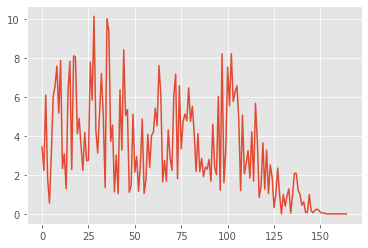

In [ ]:
%matplotlib inline
# Evolución de la optimización
fig = plt.figure(figsize=(6,4))
enjambre.resultados_df['mejor_valor_enjambre'].plot()

**Gif animado para a optimización de Rastrigin con enjambres**

In [ ]:
# Representación evolución partículas gráfico animado.

# Se extrae la posición de las partículas en cada iteración del enjambre

def extraer_posicion(particula):
    posicion = particula.posicion
    return(posicion)

lista_df_temp = []

for i in np.arange(len(enjambre.historico_particulas)):
    posiciones = list(map(extraer_posicion, enjambre.historico_particulas[i]))
    df_temp = pd.DataFrame({"iteracion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,iteracion,posicion,x_0,x_1
0,0,"[-1.389037753075123, 0.07531199872702476]",-1.389038,0.075312
1,0,"[2.257062937830117, -1.8070700802003636]",2.257063,-1.807070
2,0,"[2.3024511985357368, -1.918819708913142]",2.302451,-1.918820
3,0,"[0.03992474761206832, 0.42904450268329075]",0.039925,0.429045
4,0,"[-1.3603210828739807, -1.2738380302956476]",-1.360321,-1.273838


In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8,5))
plt.xlim(-3,3)
plt.ylim(-2,3)

def animate(i):
    p2 = fig.clear()
    plt.xlim(-3,3)
    plt.ylim(-2,3)
    df_posiciones_i = df_posiciones[df_posiciones["iteracion"] == i][["x_0", "x_1"]] #select data range
    p1 = plt.contour(X, Y, rast(X, Y), 35, cmap='RdGy')
    p2 = plt.scatter(df_posiciones_i["x_0"], df_posiciones_i["x_1"])

ani4 = matplotlib.animation.FuncAnimation(fig, animate, repeat = True, blit = True)

<IPython.core.display.Javascript object>

In [ ]:
# Guardar la animación como mp4
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, bitrate=1800)
ani4.save('animacion_pso_rast.mp4', writer=writer)

In [ ]:
HTML(ani4.to_html5_video())


**Optimización de la función Rastrigin por evolucion diferencial**

Definiión de la función objetivo, graficación de los resultados.

In [ ]:
# objective function
def objrast(v):
	x, y = v
	return 20 + x**2 + y**2 - 10*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))

#Almacenando la información del progreso
progress = []
progress_val = []

def cb(v, convergence):
    progress.append(v)
    progress_val.append(objrast(v))
 
# define range for input
r_min, r_max = -5.0, 5.0
# define the bounds on the search
bounds = [[r_min, r_max], [r_min, r_max]]

# perform the differential evolution search
result = differential_evolution(objrast, bounds, disp=False, callback=cb)

progress = np.array(progress)
progress_val = np.array(progress_val)

# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objrast(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 1833
Solution: f([1.85924609e-09 1.11076148e-09]) = 0.00000


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2,1,2)
ax.plot(progress_val)
ax.set_title('Convergencia de la solución en cada iteración')
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(progress[:,0],progress[:,1])
ax.set_title('Valores que toma (x,y)')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Valores que toma (x,y)')

Los resultados por evolución diferencial son rápidos y el algoritmo converge a los valores (0,0). se presenta la animación de la implementación.

In [ ]:
example = "rastrigin"
def rastrigin(w):
	return 20 + np.power(w[:,0],2) + np.power(w[:,1],2) - 10*np.cos(2*np.pi*w[:,1])


class ShowEvolution:

    def __init__(self, example):
        self.model = DifferentialEvolution(scaling_rate=0.7, crossover_rate=0.6, population_size=15)
        self.example = example
        self.range = [-2,3]
        self.objective = rastrigin
        self.delta = 0.1
        self.model.set_objective(self.objective)
        self.model.set_range("w1", self.range)
        self.model.set_range("w2", self.range)
        self.model.evolve()

        self.dx, self.dy = self.delta, self.delta

        tau = np.mgrid[slice(self.range[0], self.range[1] + self.dy, self.dy),
                       slice(self.range[0], self.range[1] + self.dx, self.dx)]

        self.X = tau[0, :-1, :-1]
        self.Y = tau[1, :-1, :-1]
        self.Z = np.zeros(shape=(tau.shape[1], tau.shape[2]))
        
        for m in range(tau.shape[1]):
            for n in range(tau.shape[2]):
                self.Z[n, m] = self.objective(tau[:, n, m].reshape(1, -1))

    def show(self):
        self.fig, self.ax = plt.subplots()
        self.make_nice_contours(self.ax, self.fig)

        self.ani = animation.FuncAnimation(self.fig, self.update,
                                           init_func=self.setup_plot,
                                           frames=np.arange(len(self.model.all_generations)),
                                           interval=50,
                                           blit=True,
                                           repeat=False)
        #Writer = animation.writers['ffmpeg']
        #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        #self.ani.save('example.mp4', writer=writer)
        #HTML(self.ani.to_html5_video())
        #return self.ani
        plt.close()
        return HTML(self.ani.to_html5_video())      
        
    def make_nice_contours(self, ax, fig):
        Z = self.Z[:-1, :-1]
        
        if self.example == "griewank":
            levels = MaxNLocator(nbins=50).tick_values(Z.min(), Z.max())
            
        else:
            levels = FixedLocator([0.05, 0.1, 0.25, 0.5, 1, 2.5, 5 , 7.5,
                                   10, 20, 40, 80, 160, 320, 640, 1280]).tick_values(vmin=0, vmax=1280)
            
        cmap = plt.get_cmap('coolwarm')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        cf = ax.contourf(self.X + self.dx / 2., self.Y + self.dy / 2., Z,
                         levels=levels,
                         cmap=cmap,
                         norm=norm)
        ax.set_xlabel("$p_{1}$")
        ax.set_ylabel("$p_{2}$")
        return plt
    
    def update(self, i):
        """Update the scatter plot."""
        data = self.model.all_generations[i]
        self.scat.set_offsets(data)
        return self.scat,

    def setup_plot(self):
        data = self.model.all_generations[0]
        x = data[:, 0]
        y = data[:, 1]
        self.scat = self.ax.scatter(x, y, c="black", marker='o', s=15)
        self.ax.set_xlim([self.range[0], self.range[1]])
        self.ax.set_ylim([self.range[0], self.range[1]])
        return self.scat,


In [ ]:
gwc = ShowEvolution(example)
gwc.show()

Stopped at generation 38


<IPython.core.display.Javascript object>

**Conclusiones**


*   Las técnicas metaheurísticas tienen gran ventaja para encontrar soluciones de forma descentralizada. Aplicando comportamientos vistos en la naturaleza.
*   Los métodos de descenso por gradiente ofrecen soluciones prácticas a problemas sencillos, sin embargo tiene la dificultad de estancarse en un óptimo local, además depende exclusivamente en los pasos con los que avanza la solución, su condición inicial y la complejidad que existe para conseguir su gradiente.
*    Para el metodo del descenso del gradiente e simportant tener en cuenta los outliers dentro de la muestra ya que pueden desviar al algoritmo de la trayectoria optima.
*   Los metodos de optimización por evolución diferencial tienen la caracteristica de converger rapidamente por lo que se debe tener precaución de que no converga prematuramente. 



*   Optimización con algoritmo genético Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py01_optimizacion_ga
*   Optimización con enjambre de partículas (Particle Swarm Optimization) by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py02_optimizacion_pso
*   https://machinelearningmastery.com/differential-evolution-global-optimization-with-python/

* https://www.kaggle.com/allunia/differential-evolution
* https://es.wikipedia.org/wiki/Optimizaci%C3%B3n_por_enjambre_de_part%C3%ADculas
* https://es.wikipedia.org/wiki/Evoluci%C3%B3n_diferencial



